In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kabure/german-credit-data-with-risk")

print("Path to dataset files:", path)

c:\Work\GermanCreditRisk\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\M4800\.cache\kagglehub\datasets\kabure\german-credit-data-with-risk\versions\1


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'numpy'

In [112]:
import pandas as pd
from typing import List

dataset=pd.read_csv('german_credit_data.csv')

In [4]:
dataset.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


## Target ratio

In [2]:
print(dataset['Risk'].value_counts())

print(f"positive target ratio: {dataset.where(dataset['Risk'] == 'bad')[['Risk']].count()/dataset[['Risk']].count()}")

NameError: name 'dataset' is not defined

# EDA - categorical features

### restart utils

In [128]:
import importlib
import utils
importlib.reload(utils)


<module 'utils' from '/Users/tramynguyen/Work/German-Credit-Risk/utils.py'>

## cont

In [6]:
from utils import visualize_category_features

Matplotlib is building the font cache; this may take a moment.


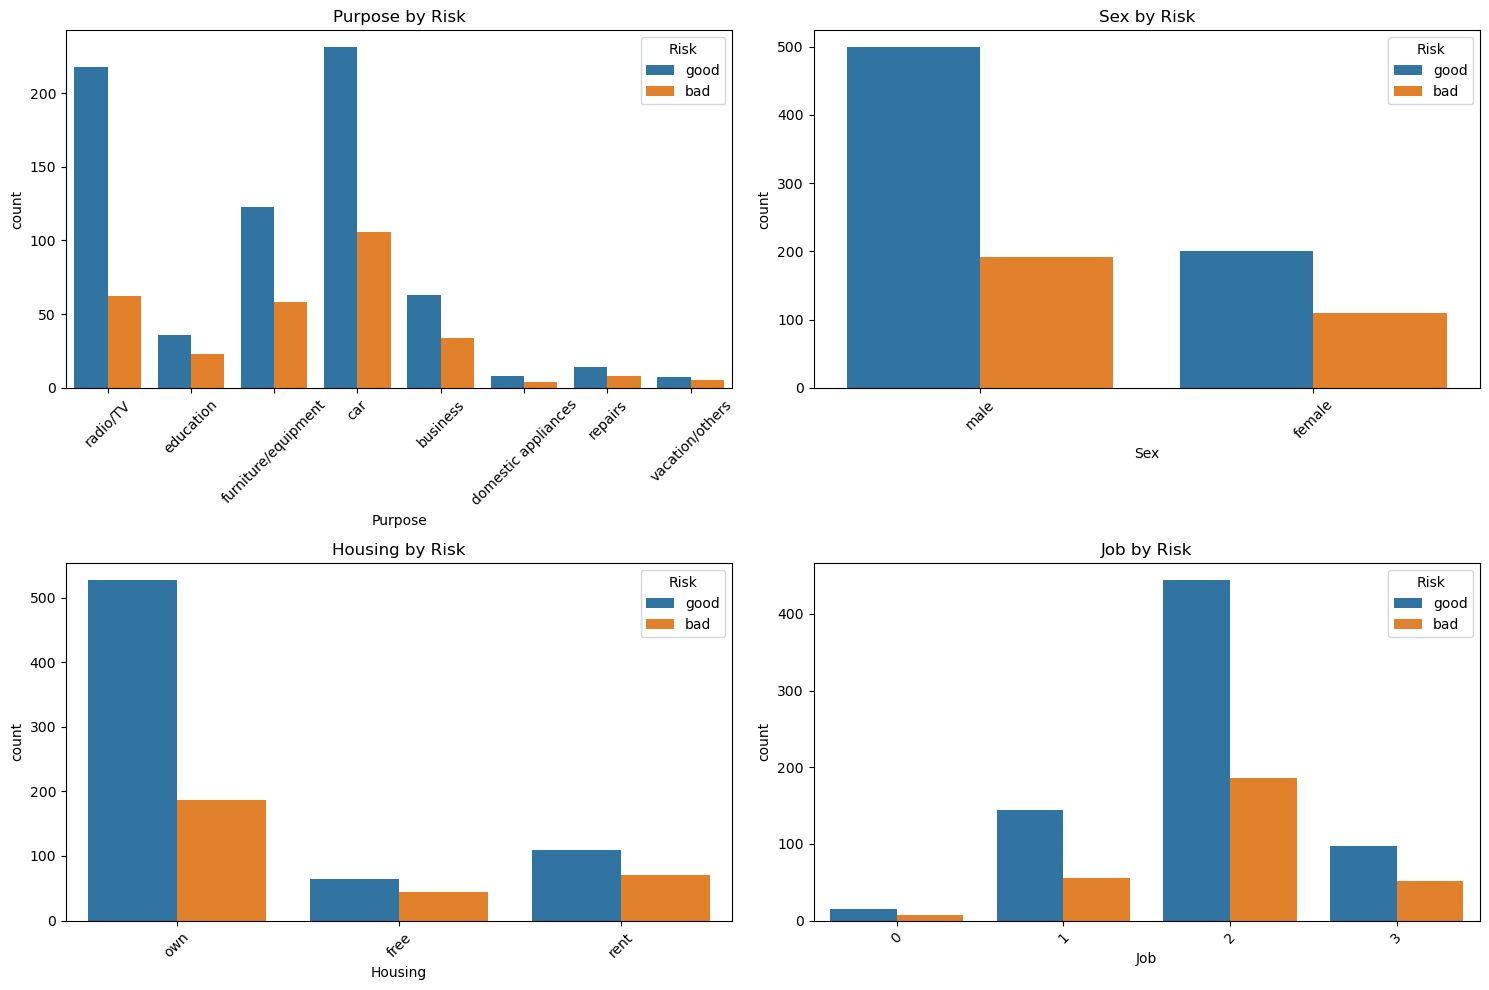

In [7]:
visualize_category_features(
    dataset=dataset,
    cat_columns=['Purpose', 'Sex', 'Housing', 'Job']
)

# EDA - Numerical features

In [8]:
from utils import visualize_numerical_features

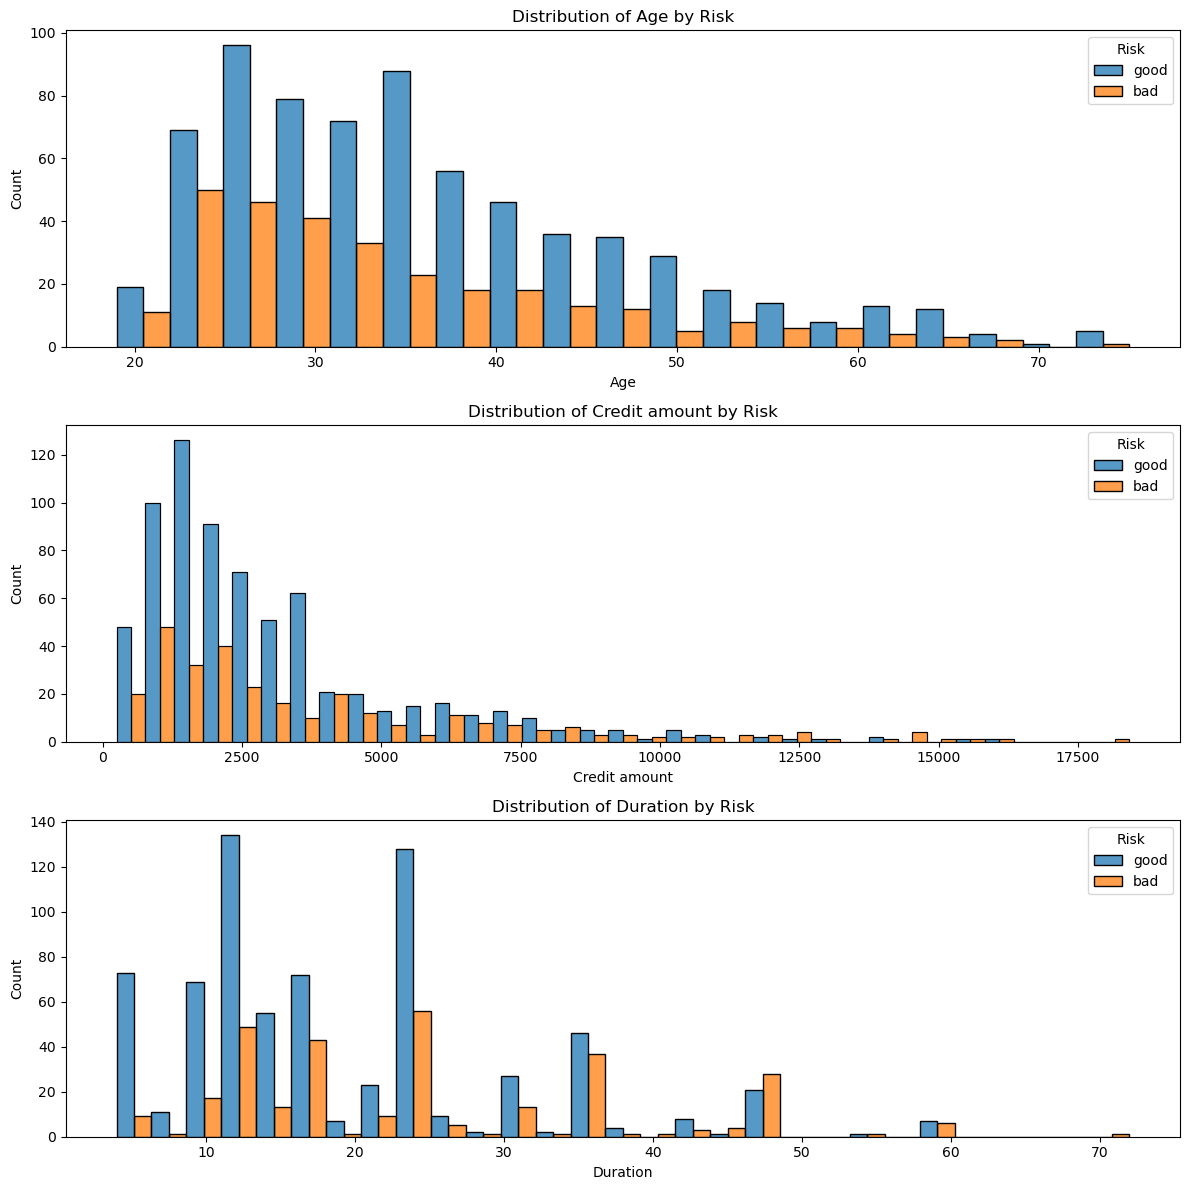

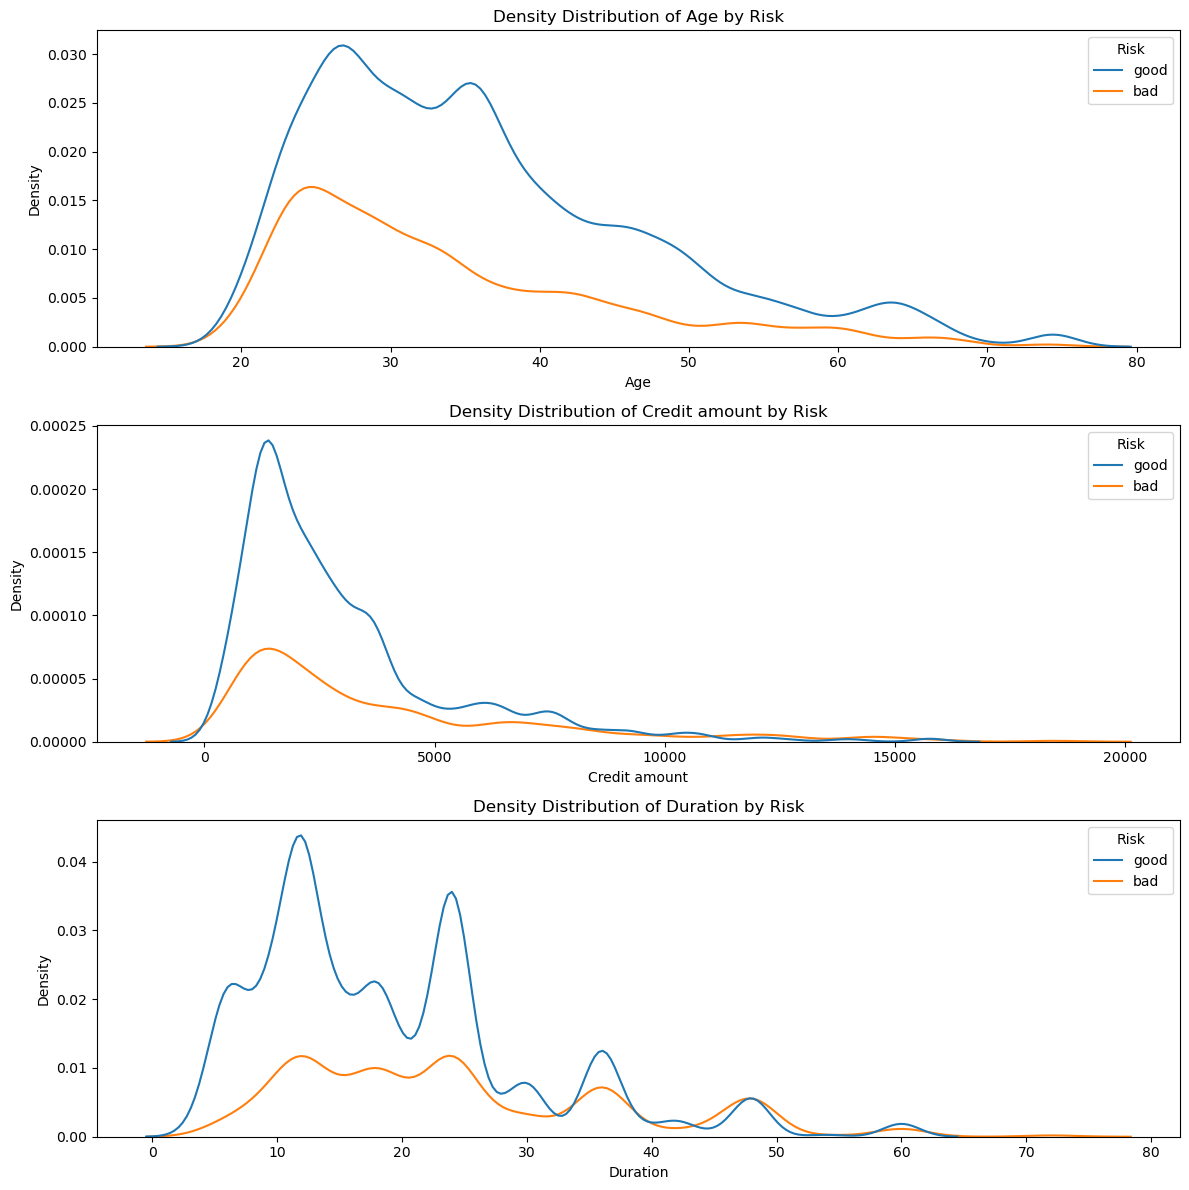

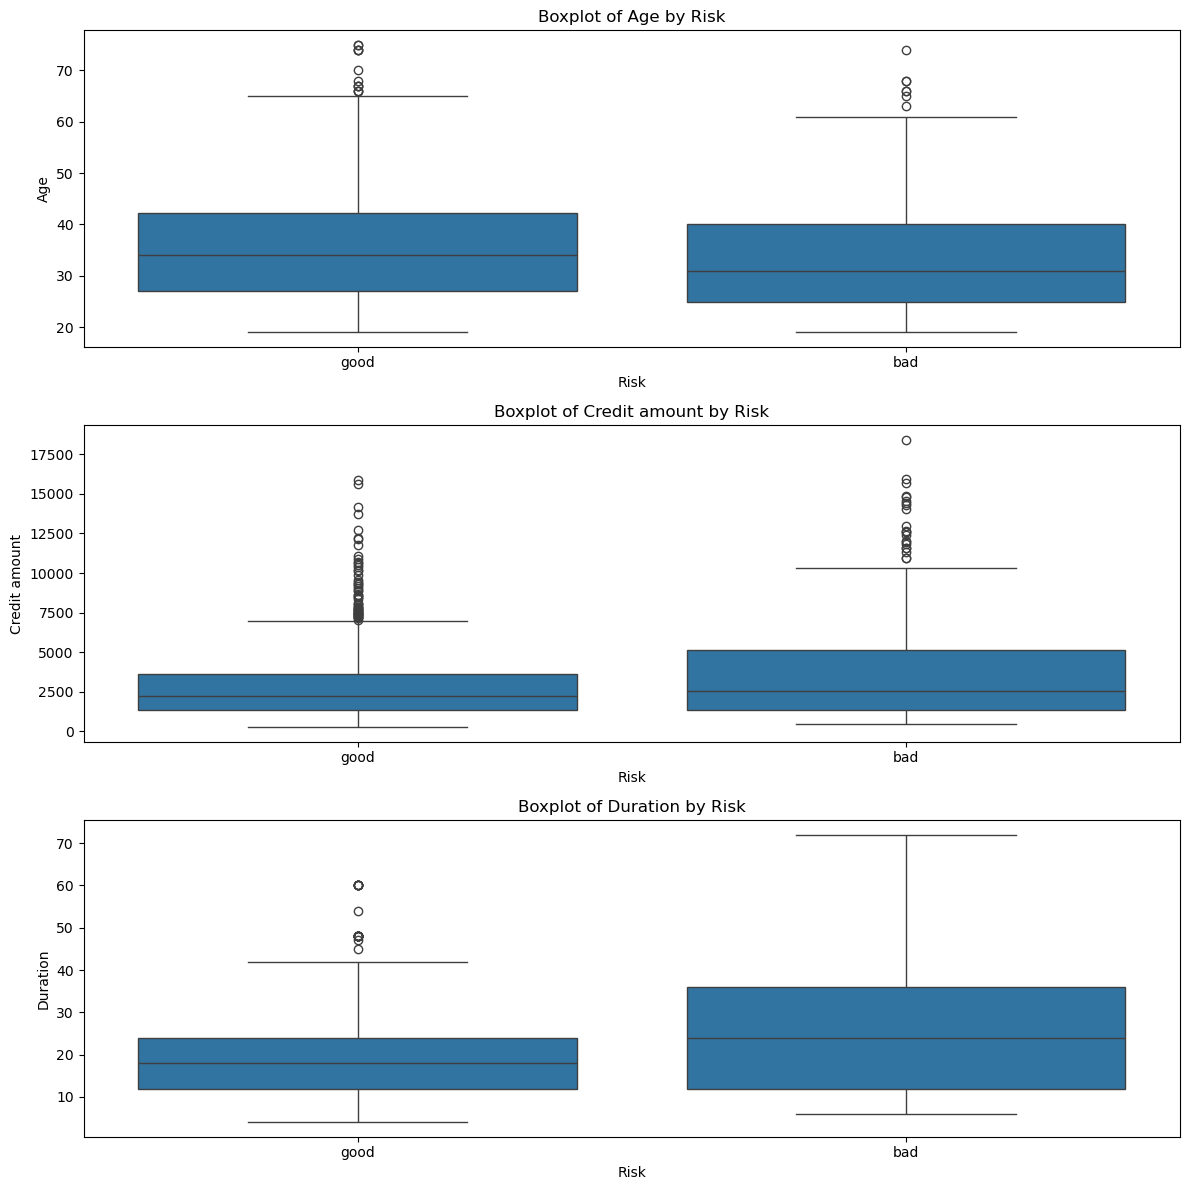

In [9]:
visualize_numerical_features(
    dataset=dataset,
    num_columns=['Age', 'Credit amount', 'Duration']
)

# EDA - Numerical and Categorical Features

In [3]:
from utils import plot_categorical_violin

In [39]:
dataset.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

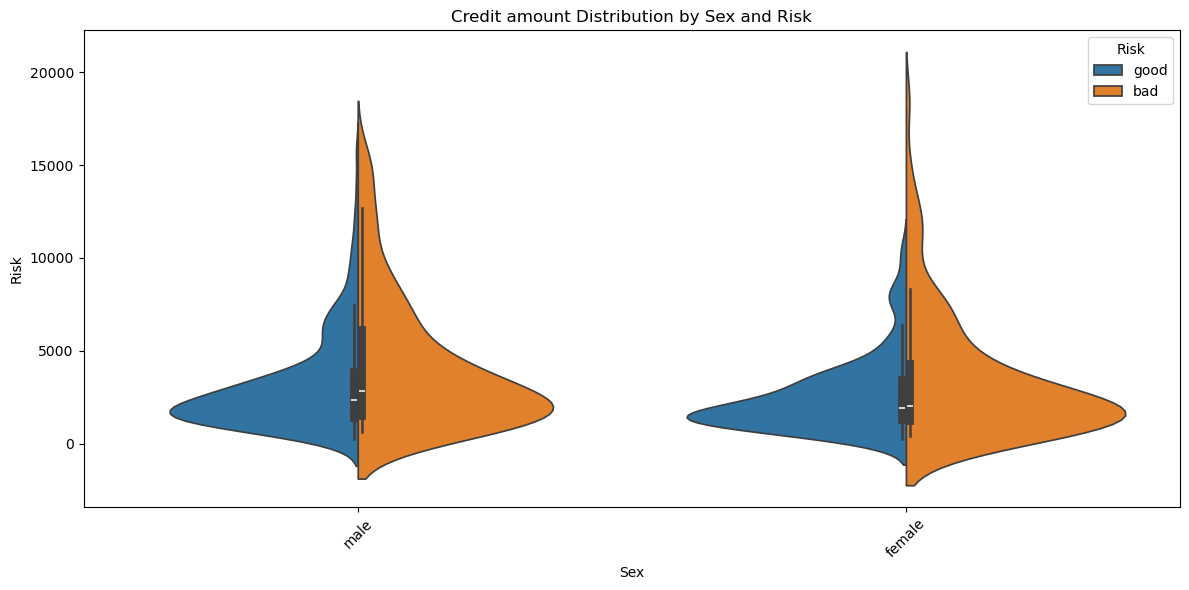

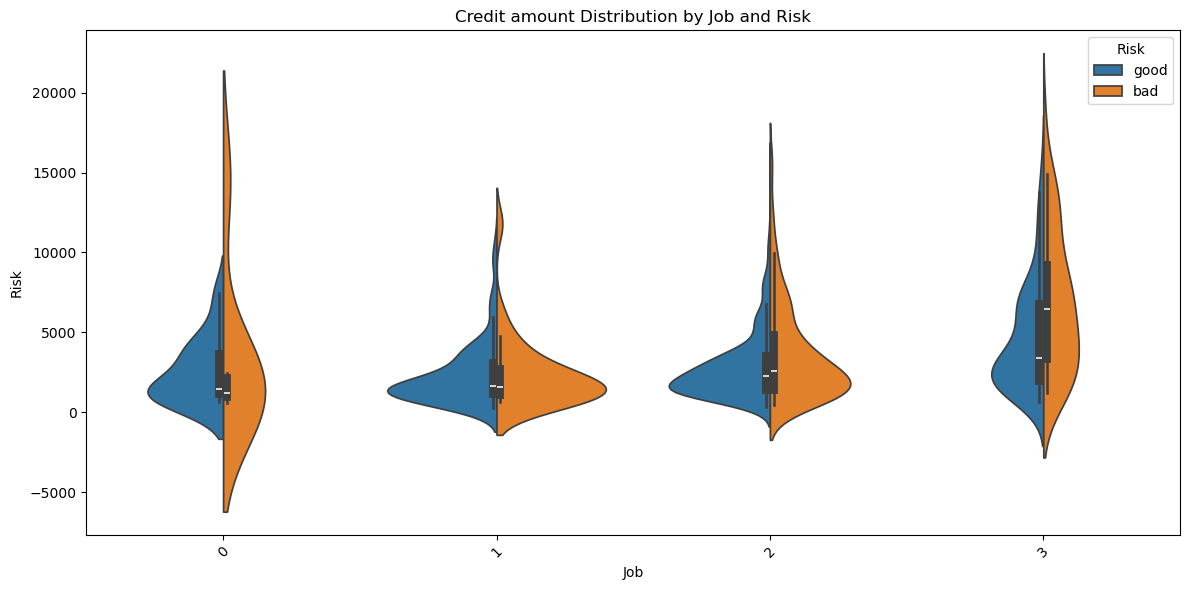

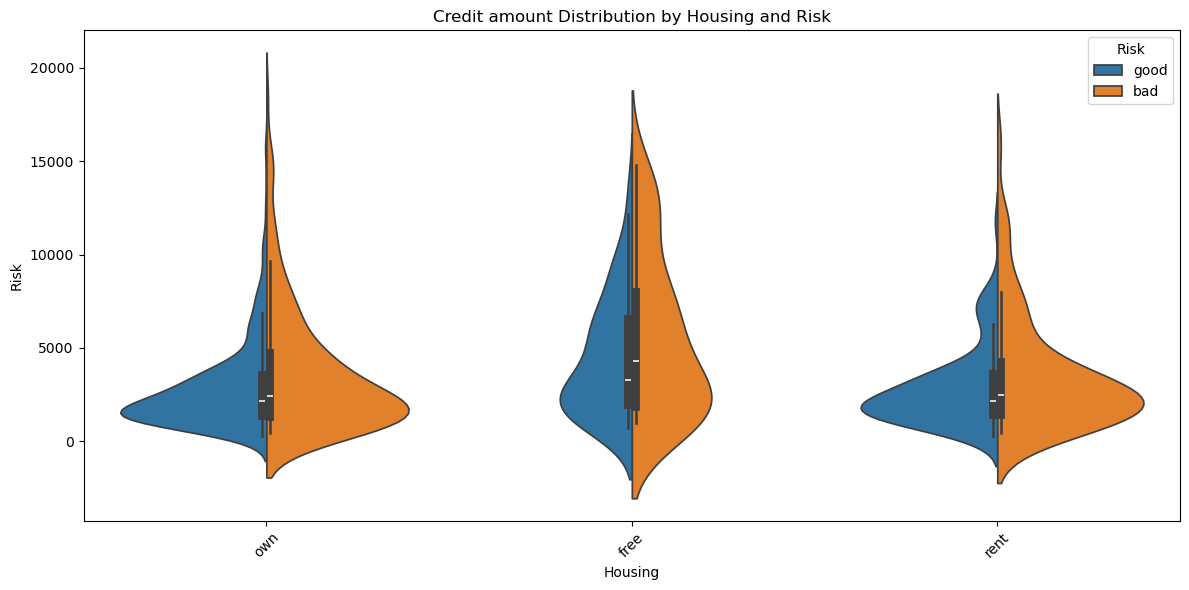

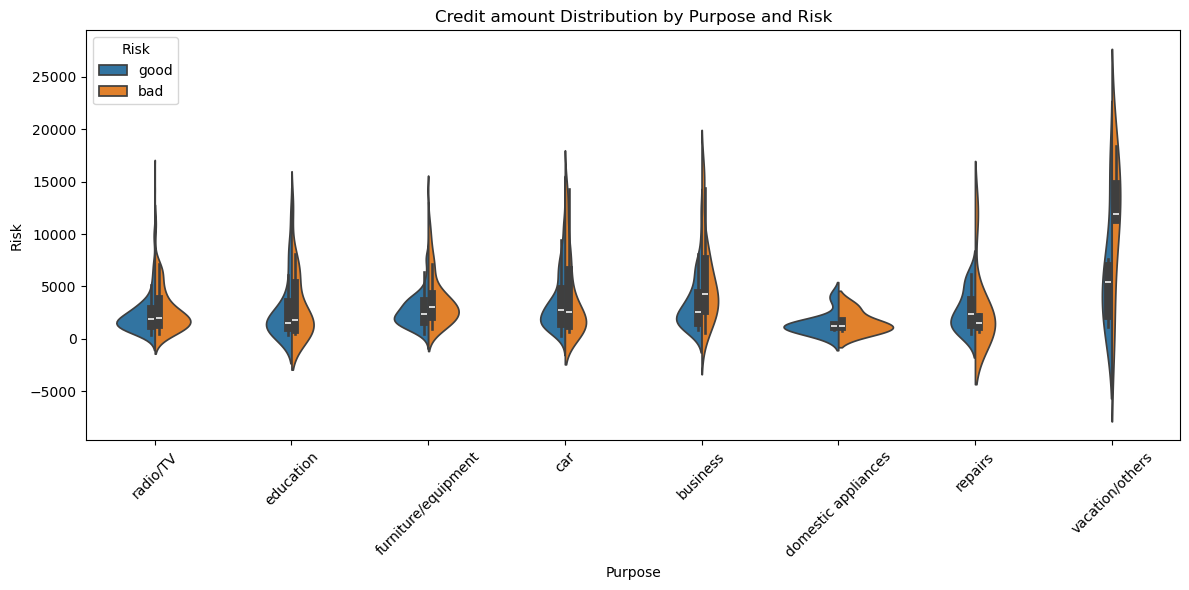

In [4]:
plot_categorical_violin(
    dataset=dataset,
    cat_column=['Sex','Job','Housing','Purpose'],
    num_column= 'Credit amount',
    target_column= 'Risk'
)

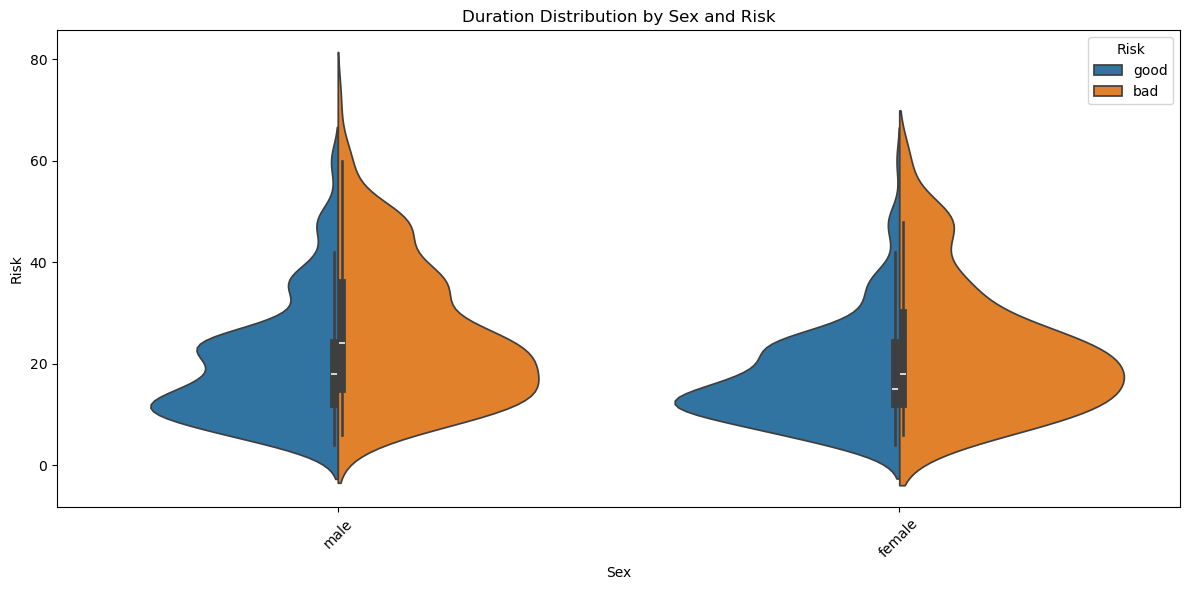

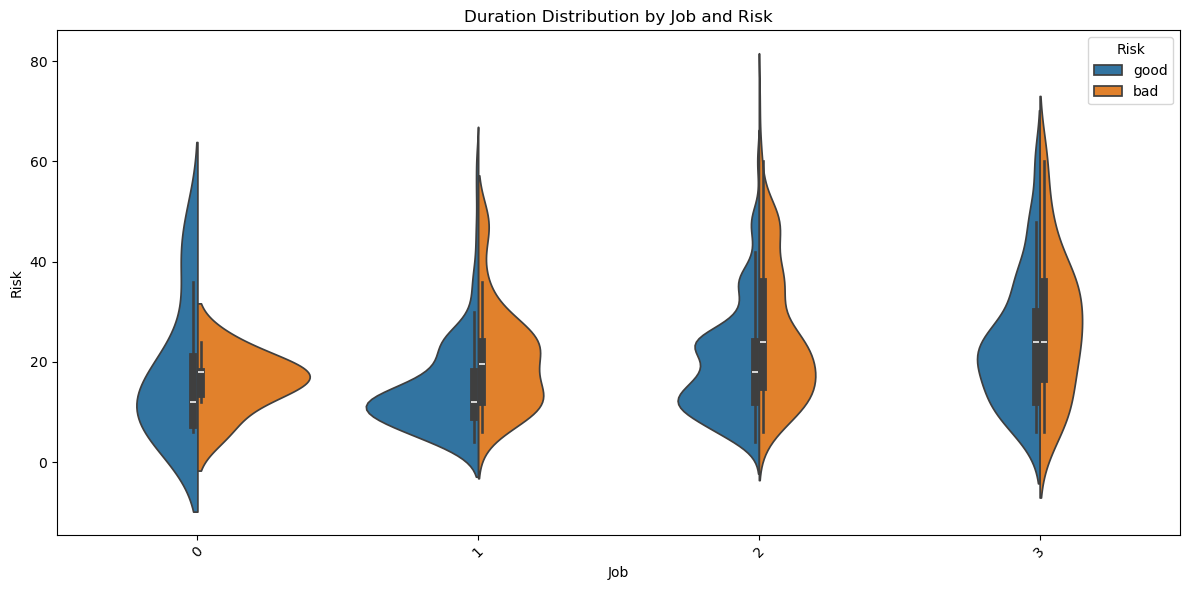

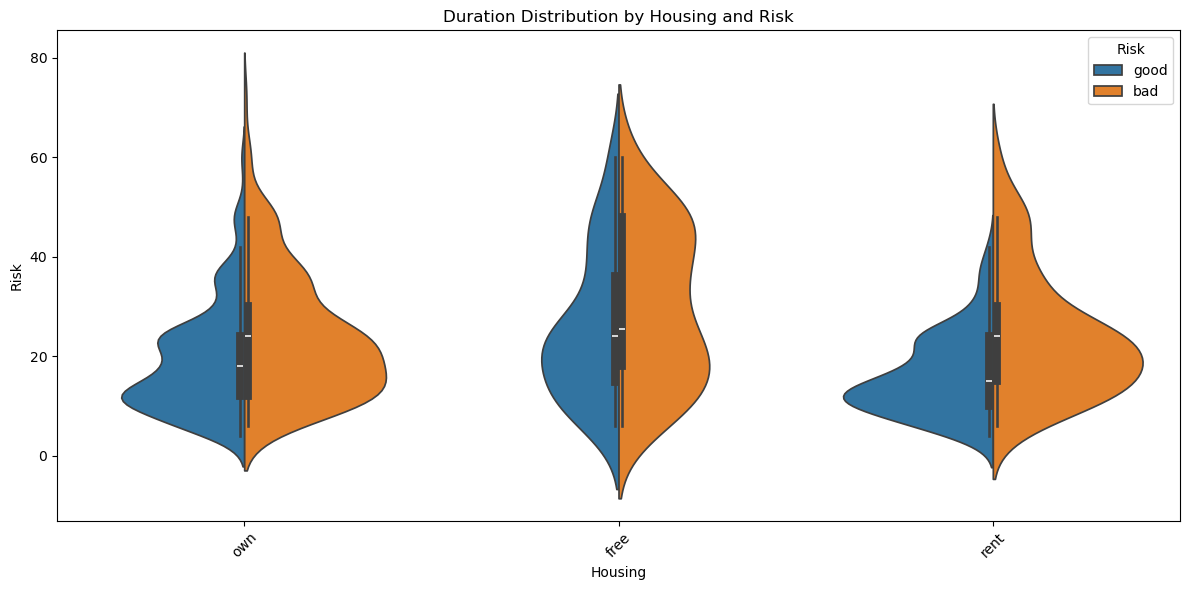

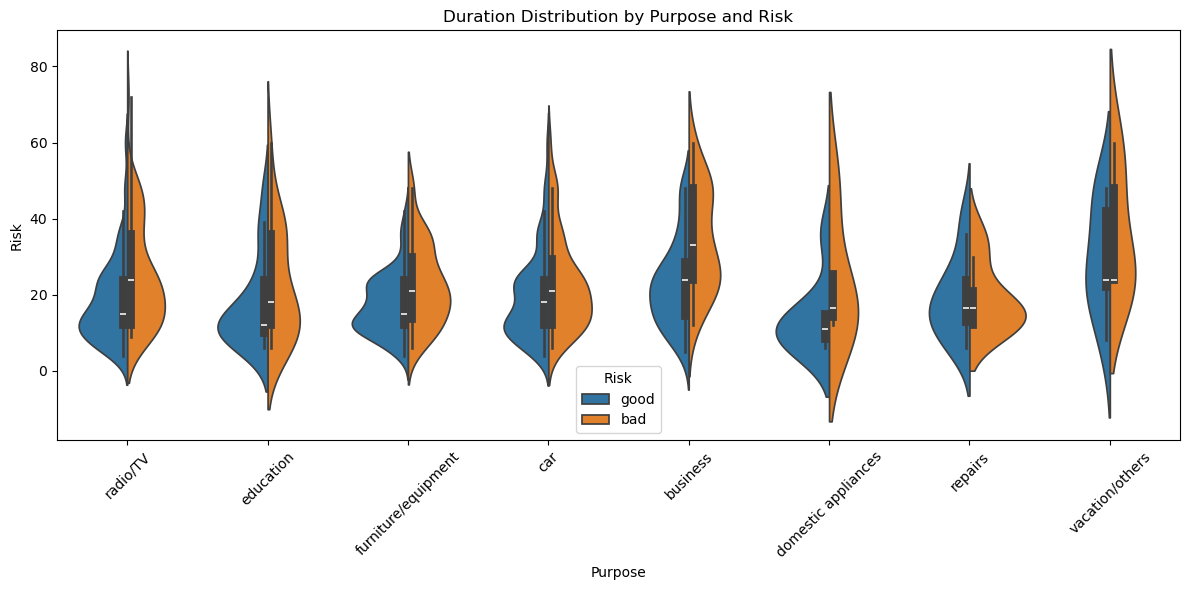

In [5]:
plot_categorical_violin(
    dataset=dataset,
    cat_column=['Sex','Job','Housing','Purpose'],
    num_column= 'Duration',
    target_column= 'Risk'
)

Comment:
Sex: Distribution of credit amount and duration vary little between female and male. No strong evidence high impact on credit risk

Job: Different jobs change the distribution of credit amount and duration significantly
    Job 0: more volatile bad/good proportion
            higher bad ratio in larger loans
            lower duration
            with lower duration having high bad ratio, strongly implying perceived risks.
    Job 1: stable risk profiles
        moderate credit amount and duration
        quite balanced good/bad ratio across credit amount and duration 
        slightly more good ratio in lower duration
Job 2: stable risk profiles but slightly longer duration and higher credit amount than Job 1 (implied worser perceived risk)
        balanced good/bad ratio across segments
Job 3: good group with higher credit amount, duration and more balanced good/bad ratios
        higher perceived safeness with higher duration and larger loans

Job 1 and Job 2 needs more information (other features) to decide whether good or bad, besides credit amount and duration. But overally, Job is evidently a strong factor giving diversification among its categories.

Purpose: visibly influential factor
        Vacation/others: Longer duration and higher credit amount, balanced good/bad ratios
        Business: higher bad ratio when duration increases
        Domestic appliances: smaller loans, higher bad ratio if longer duration
        Other purpose: moderate durations and loans, balanced good/bad ratios



# Processing

In [113]:
from utils import  processing_numerical_columns

from utils import  process_categorical_features


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder


In [114]:
dataset = process_categorical_features(
    dataset = dataset,
    categories_columns=['Age', 'Sex', 'Job', 'Housing','Purpose','Saving accounts','Checking account','Risk'],
    fill_value = 'missing',
    encoding_type= 'label'
)

In [115]:
dataset = processing_numerical_columns(
    dataset = dataset,
    numerical_columns = ['Credit amount','Duration','Age'],
    fill_strategy='mean',
    handle_outliers= False,
    scaling_type='robust'
)

# Modelling

In [143]:
from utils import split_train_test
from utils import create_model_pipeline
from utils import train_evaluate
from utils import cross_validate_models

In [135]:
X_train, X_test , y_train, y_test = split_train_test(
    dataset = dataset,
    target_variable= 'Risk',
    test_size = 0.2,
    is_rebalance= True,
    positive_num= 560,
    negative_num= 240
)

Risk
1    560
0    240
Name: count, dtype: int64


In [144]:
pipeline = create_model_pipeline(
    model_name = 'rf'
)

metrics, trained_model = train_evaluate(
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    model = pipeline,
    threshold = 0.5
)

In [145]:
metrics

{'accuracy': 0.755,
 'precision': 0.7861635220125787,
 'recall': 0.8928571428571429,
 'f1': 0.8361204013377926,
 'auc': 0.7413095238095238}

# Evaluation and Tuning

In [146]:
cross_validate_models(
    X=X,
    y=y
)

/opt/homebrew/Caskroom/miniconda/base/envs/myvenv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myvenv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and 

[LightGBM] [Info] Number of positive: 560, number of negative: 240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/opt/homebrew/Caskroom/miniconda/base/envs/myvenv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myvenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myvenv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tag

{'lr': {'mean_auc': 0.6640476190476192, 'std_auc': 0.024009044969819412},
 'rf': {'mean_auc': 0.7298928571428572, 'std_auc': 0.024070427655701183},
 'lgb': {'mean_auc': 0.6918571428571428, 'std_auc': 0.03239054479767589}}

In [139]:
from utils import  plot_threshold_analysis
from utils import find_optimal_threshold
 

/Users/tramynguyen/Work/German-Credit-Risk/utils.py:214: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


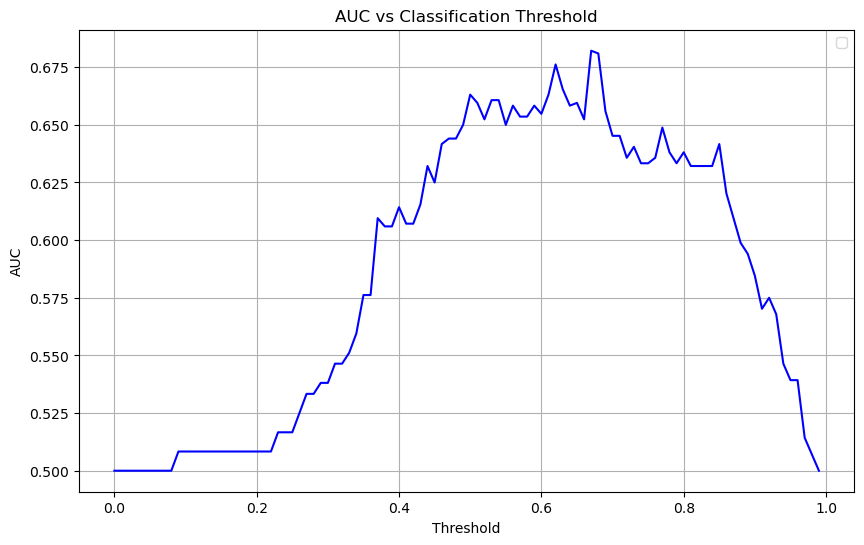

In [147]:
plot_threshold_analysis(
    model = pipeline,
    X_test = X_test,
    y_test = y_test,
    target_label = 1
)

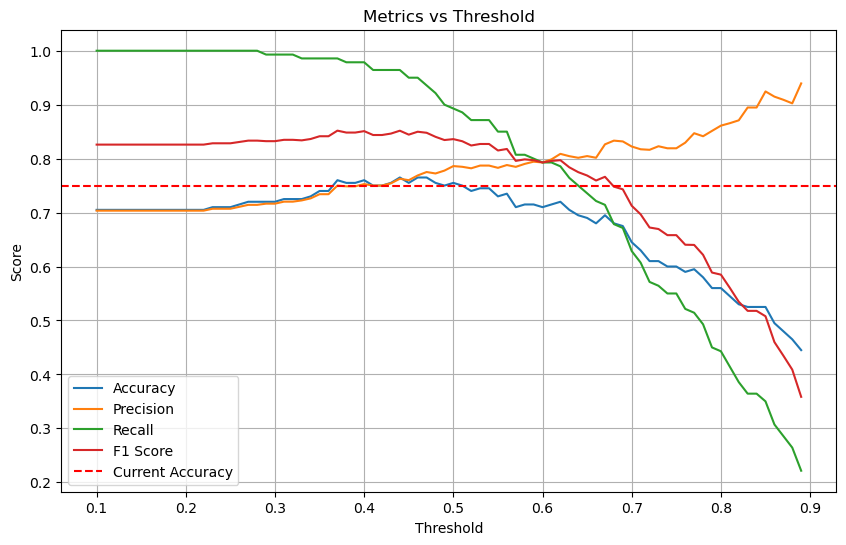

Best threshold for accuracy: 0.440
Best accuracy score: 0.765

Best threshold for F1: 0.370
Best F1 score: 0.852


In [148]:
best_threshold_accuracy, best_threshold_f1 = find_optimal_threshold(
    model = pipeline,
    X_test = X_test,
    y_test = y_test,
    current_accuracy= 0.75
)

In [150]:
metrics, trained_model = train_evaluate(
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    model = pipeline,
    threshold = 0.44
)

metrics

{'accuracy': 0.765,
 'precision': 0.7627118644067796,
 'recall': 0.9642857142857143,
 'f1': 0.8517350157728707,
 'auc': 0.7413095238095238}